In [1]:
import numpy as np
import torch
from transformers import AutoTokenizer, LlamaForCausalLM
import pandas as pd
from tqdm import tqdm  # 引入进度条库
import os

In [2]:
# 初始化存储变量
all_words = []
all_word_embeddings = []

In [3]:
output_folder = "/share/home/pwmat/Huggingface_Model_Downloades/model_test_ChemDFM-13B-v1.0/allwords_bandgap_0.9_1.4_data/"
# 遍历文件夹中的所有CSV文件
csv_files = [f for f in os.listdir(output_folder) if f.endswith(".csv")]

print("开始加载词汇和词向量...")
for csv_file in tqdm(csv_files, desc="Loading CSV Files", unit="file"):
    file_path = os.path.join(output_folder, csv_file)
    data = pd.read_csv(file_path)

    # 判断文件中是否包含词汇列
    if "Word" in data.columns:
        words = data["Word"].tolist()
        embeddings = data.iloc[:, 1:].values  # 假设其他列为词向量
    elif "ChemicalFormula" in data.columns:  # 化学式文件
        words = data["ChemicalFormula"].tolist()
        embeddings = data.iloc[:, 1:].values  # 假设其他列为词向量
    else:
        raise ValueError(f"文件 {csv_file} 中未找到词汇或化学式列")

    # 添加到总列表
    all_words.extend(words)
    all_word_embeddings.extend(embeddings)

# 转换为NumPy数组
all_word_embeddings = np.array(all_word_embeddings)

# 建立词汇和词向量的键值对
word_to_embedding = {word: embedding for word, embedding in zip(all_words, all_word_embeddings)}

print(f"加载完成，共加载 {len(all_words)} 个词汇及其词向量。")

开始加载词汇和词向量...


Loading CSV Files: 100%|████████████████████████████████████████████████████████████████████| 24/24 [01:03<00:00,  2.66s/file]


加载完成，共加载 105839 个词汇及其词向量。


In [4]:
print("检查并清理嵌入数据中的 NaN 或 Inf 值...")
if np.any(np.isnan(all_word_embeddings)) or np.any(np.isinf(all_word_embeddings)):
    print("发现 NaN 或 Inf 值，正在处理...")
    # 使用均值填充 NaN 或 Inf 值
    embedding_means = np.nanmean(all_word_embeddings, axis=0)
    all_word_embeddings = np.where(
        np.isnan(all_word_embeddings) | np.isinf(all_word_embeddings),
        embedding_means,  # 用每一列的均值填充
        all_word_embeddings
    )
print("数据清理完成！")

检查并清理嵌入数据中的 NaN 或 Inf 值...
数据清理完成！


In [5]:
from sklearn.decomposition import PCA  # 引入PCA
# 使用PCA将词向量降至150维
print("开始PCA降维到50维...")
pca = PCA(n_components=50, random_state=42)
all_word_embeddings_pca = pca.fit_transform(all_word_embeddings)
print("PCA降维完成！")

开始PCA降维到50维...
PCA降维完成！


In [6]:
from umap import UMAP
# 使用UMAP进一步降维
print("开始UMAP降维...")
reducer = UMAP(n_components=2, random_state=42, verbose=True, n_jobs=-1)
with tqdm(total=1, desc="UMAP Reduction", unit="step") as pbar:
    embeddings_umap = reducer.fit_transform(all_word_embeddings_pca)
    pbar.update(1)

# 降维完成，输出降维结果
print("UMAP降维完成！")

开始UMAP降维...


UMAP Reduction:   0%|                                                                                 | 0/1 [00:00<?, ?step/s]

UMAP(n_jobs=1, random_state=42, verbose=True)
Mon Mar 10 07:58:27 2025 Construct fuzzy simplicial set
Mon Mar 10 07:58:27 2025 Finding Nearest Neighbors
Mon Mar 10 07:58:27 2025 Building RP forest with 21 trees


/share/home/pwmat/anaconda3/envs/llm/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Mon Mar 10 07:58:30 2025 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	Stopping threshold met -- exiting after 4 iterations
Mon Mar 10 07:58:40 2025 Finished Nearest Neighbor Search
Mon Mar 10 07:58:42 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Mar 10 08:00:18 2025 Finished embedding


UMAP Reduction: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [01:51<00:00, 111.81s/step]

UMAP降维完成！


In [7]:
print("GaAlAs" in all_words)

True


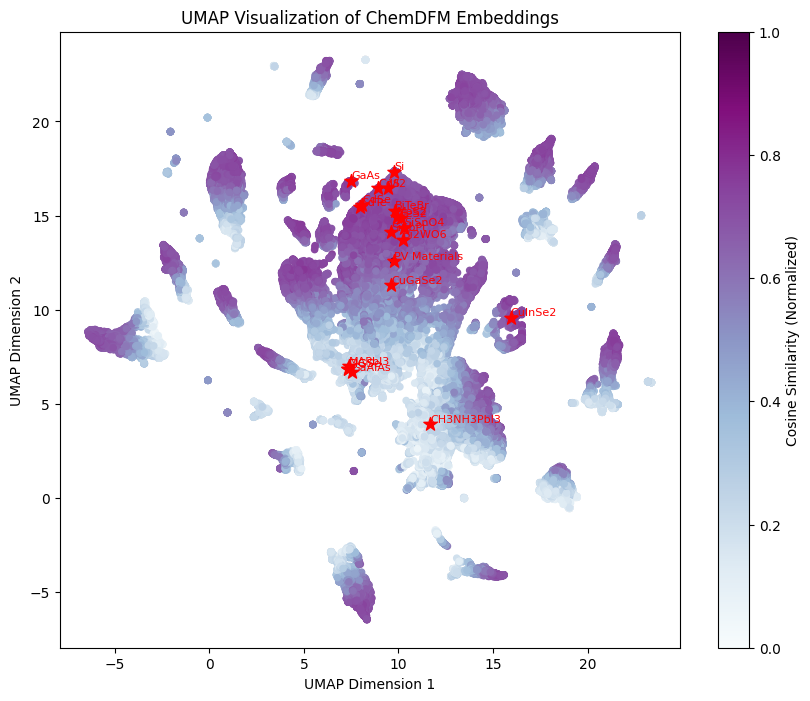

降维可视化完成，图像已保存到 /share/home/pwmat/Huggingface_Model_Downloades/model_test_ChemDFM-13B-v1.0/allwords_bandgap_0.9_1.4_data/umap_visualization.svg


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os

# 可视化示例
highlighted_words = [
    "PV Materials", 
    "CdS",    # 硫化镉 - 常用于薄膜太阳能电池的窗口层
    "CdTe",   # 碲化镉 - 薄膜太阳能电池中的主要吸光材料
    "CdSe", 
    "CIGS",
    "CuInSe2", # 硒化铜铟 - CIGS薄膜太阳能电池的核心材料
    "CuGaSe2", # 硒化铜镓 - 用于CIGS电池中
    "Si",     # 硅 - 单晶和多晶硅电池是最常见的光伏材料
    "GaAs",   # 砷化镓 - 高效单结和多结光伏电池
    "CH3NH3PbI3", # 钙钛矿材料 - 下一代高效光伏材料
    "Bi2WO6",
    "MAPbI3",
    "CIGSe",
    "GaAlAs",
    "SiSnO4", 
    "SiSbPt",
    "MoS2",
    "FeS2",
    "VI2",
    "BiTeBr"
]
target_word = "PV Materials"  # 示例目标词汇

# 计算与目标词的余弦相似性
target_embedding = word_to_embedding[target_word]
cos_similarities = cosine_similarity(all_word_embeddings, [target_embedding])

# 标准化余弦相似性
cos_similarities_normalized = (cos_similarities - cos_similarities.min()) / (cos_similarities.max() - cos_similarities.min())

# 绘制降维散点图
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=cos_similarities_normalized.squeeze(),
    cmap=plt.cm.BuPu,
    s=20
)

# 标记高亮词汇
for word in highlighted_words:
    if word in word_to_embedding:
        idx = all_words.index(word)
        plt.scatter(embeddings_umap[idx, 0], embeddings_umap[idx, 1], color="red", marker="*", s=100)
        plt.text(embeddings_umap[idx, 0], embeddings_umap[idx, 1], word, fontsize=8, ha="left", va="bottom", color="red")

plt.title("UMAP Visualization of ChemDFM Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label("Cosine Similarity (Normalized)")

# 矢量图保存路径
output_image = os.path.join(output_folder, "umap_visualization.svg")  # 保存为矢量图（PDF 格式）
plt.savefig(output_image, format="svg", bbox_inches="tight")  # 保存为矢量图
plt.show()

print(f"降维可视化完成，图像已保存到 {output_image}")


In [9]:
try:
    import plotly.express as px
    import plotly.graph_objects as go

    # 创建 hover 信息，包含所有点的化学式和余弦相似性
    hover_text = [
        f"Word: {all_words[i]}<br>Cosine Similarity: {cos_similarities_normalized[i][0]:.4f}" 
        for i in range(len(all_words))
    ]

    # 创建普通点的散点图
    base_trace = go.Scattergl(
        x=embeddings_umap[:, 0],
        y=embeddings_umap[:, 1],
        mode='markers',
        marker=dict(
            size=12,
            color=cos_similarities_normalized.squeeze(),
            colorscale="BuPu",  # 使用更专业的颜色映射
            opacity=0.8,
            colorbar=dict(  # 显示颜色条
                title="Cosine Similarity",
                titleside="right",
                titlefont=dict(size=14),
                tickfont=dict(size=12),
                thickness=20,
                len=0.75
            )
        ),
        text=hover_text,
        hovertemplate="%{text}<extra></extra>",  # 确保显示 hover 信息
        name="All Points"  # 普通点的名称
    )

    # 创建图表对象
    interactive_fig = go.Figure(data=[base_trace])

    # 添加高亮点的 trace，并确保它们在上层
    for word in highlighted_words:
        if word in word_to_embedding:
            print(word)
            idx = all_words.index(word)
            highlight_trace = go.Scattergl(
                x=[embeddings_umap[idx, 0]],
                y=[embeddings_umap[idx, 1]],
                mode='markers+text',
                marker=dict(size=10, color='limegreen', symbol='circle', opacity=1),  # 高亮点设置
                text=[word],  # 显示高亮点的文本
                textposition='top center',
                textfont=dict(  # 设置文本样式
                    color="crimson",  # 调整文本颜色
                    size=14,  # 调整文本字体大小
                    family="Arial"  # 调整字体
                ),
                name=f"<b>{word}</b>",  # 高亮点的名称
                showlegend=False  # 不显示在图例中
            )
            interactive_fig.add_trace(highlight_trace)

    # 调整布局，确保颜色条和标题美观
    interactive_fig.update_layout(
        title="<b>Interactive UMAP Visualization of Word Embeddings</b>",
        template="plotly_white",  # 改为简洁的白色主题
        margin=dict(l=40, r=40, t=60, b=40),  # 优化边距
        title_font=dict(size=16),  # 图像标题字体大小
        font=dict(size=12)  # 整体字体设置
    )

    # 保存交互式图像
    interactive_fig.write_html("umap_visualization_interactive.html")
    print("交互式图像已保存为 umap_visualization_interactive.html")

except ImportError:
    print("未安装 Plotly，无法生成交互式图像。请安装 Plotly 后重试。")


PV Materials
CdS
CdTe
CdSe
CIGS
CuInSe2
CuGaSe2
Si
GaAs
CH3NH3PbI3
Bi2WO6
MAPbI3
CIGSe
GaAlAs
SiSnO4
SiSbPt
MoS2
FeS2
VI2
BiTeBr
交互式图像已保存为 umap_visualization_interactive.html


In [28]:
# 新增代码块：计算指定化学式在UMAP降维空间中的欧氏距离

# 用户可在此处修改需要比较的两个化学式
word1 = "Bi2WO6"  # 第一个化学式（可修改）
word2 = "PV Materials"  # 第二个化学式（可修改）

# 检查词汇是否存在
if word1 not in all_words or word2 not in all_words:
    missing_words = []
    if word1 not in all_words:
        missing_words.append(word1)
    if word2 not in all_words:
        missing_words.append(word2)
    print(f"以下词汇未找到: {missing_words}，请检查拼写或大小写！")
else:
    # 获取对应的UMAP坐标
    idx1 = all_words.index(word1)
    idx2 = all_words.index(word2)
    coord1 = embeddings_umap[idx1]
    coord2 = embeddings_umap[idx2]
    
    # 计算欧氏距离
    distance = np.linalg.norm(coord1 - coord2)
    
    # 输出结果
    print(f"【{word1}】与【{word2}】在UMAP空间的欧氏距离: {distance:.4f}")

【Bi2WO6】与【PV Materials】在UMAP空间的欧氏距离: 1.2467


In [11]:
# 导出高质量静态 SVG 矢量图
svg_path = "umap_visualization_high_quality.svg"
try:
    # 增加分辨率参数
    interactive_fig.write_image(svg_path, format="svg", width=1920, height=1080, scale=2)
    print(f"高质量 SVG 矢量图已成功保存为 {svg_path}")
except ImportError:
    print("请安装必要的库：plotly 和 kaleido")
    print("安装命令：pip install plotly kaleido")

高质量 SVG 矢量图已成功保存为 umap_visualization_high_quality.svg


In [12]:
# 打印与 target_word 相似性排名前 50 的词汇
similarity_scores = [(all_words[i], cos_similarities_normalized[i][0]) for i in range(len(all_words))]
sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
for rank, (word, score) in enumerate(sorted_scores, 1):
    if word == "Al23O27N5":
        print(f"{rank}: {word} (相似性: {score:.4f})")
top_50_similar_words = sorted_scores[:50]

# print("与目标词相似性排名前 50 的词汇 (基于已绘制的相似性标准化结果):")
# for rank, (word, score) in enumerate(top_50_similar_words, 1):
    # print(f"{rank}: {word} (相似性: {score:.4f})")

91036: Al23O27N5 (相似性: 0.1951)


In [ ]:
print("与目标词相似性排名前 50 的词汇 (基于已绘制的相似性标准化结果):")
for rank, (word, score) in enumerate(top_50_similar_words, 1):
    print(f"{rank}: {word} (相似性: {score:.4f})")